In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

# Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet

In [16]:
#data=pd.read_csv("../data/raw/datacontinuousstudents.csv")
datatr=pd.read_csv("datacontinuousstudents_train.csv")
datats=pd.read_csv("datacontinuousstudents_test.csv")
data=pd.concat([datatr,datats])
#data = data.set_index(['id'])
data.reset_index(inplace = True)
data = data.drop(['index'], axis = 1)
data.head()

,id,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32
0,1,-0.852667,49.856,118.8,1,0,0,0,0,16.32096,...,0.9709,0.0003,6,6,24.7138,0,0,7,0.056546,0.112860
1,3,5.951199,66.725,41.8,0,1,0,0,0,17.07023,...,0.9650,0.0000,6,6,48.3807,0,1,4,0.067855,0.133944
2,4,-2.030599,41.696,132.0,0,0,1,0,0,16.31460,...,0.0091,0.0001,6,4,59.8410,0,0,7,0.133230,0.260102
3,5,-6.143410,71.351,24.2,1,0,0,0,0,11.10790,...,0.0051,0.0000,5,7,175.9250,0,0,3,0.318584,0.627729
4,7,0.174651,67.879,42.3,0,0,0,0,1,15.07912,...,0.0022,0.0001,7,3,81.3357,0,0,5,0.219665,0.436101


## Selección de características

In [19]:
sel_fea = []
coefi = []

for j in range(1,101):
    
    train, test = train_test_split(data, test_size = 0.2, random_state=j)
    train=train.drop(['id'], axis=1)
    X_train=train.drop(['y'], axis=1)
    Y_train=train['y']
    test=test.drop(['id'], axis=1)
    X_test=test.drop(['y'], axis=1)
    Y_test=test['y']
    
    num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']
    
    num_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('imputer',SimpleImputer(strategy='median'))
        ])
    col_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_features)
        ])
    
    columns=X_train.columns.values.tolist()    
    col_transformer.fit(X_train.fillna(0))
    X_train[num_features]=col_transformer.transform(X_train.fillna(0))
    X_test[num_features]=col_transformer.transform(X_test.fillna(0))
    
    model_all_features = ElasticNet(alpha=1, l1_ratio=0.1, random_state=0)
    model_all_features.fit(X_train, Y_train)
    y_pred_test = model_all_features.predict(X_test)
    r2_score_all = r2_score(Y_test, y_pred_test)
    
    features = pd.Series(abs(model_all_features.coef_)) #esto con valor absoluto?
    features.index = X_train.columns
    features.sort_values(ascending=False, inplace=True)

    features = list(features.index)
    
    # Modelo con la característca más importante (desde la que se inicia la adición)
    model_one_feature = ElasticNet(alpha=1, l1_ratio=0.1, random_state=0)
    model_one_feature.fit(X_train[features[0]].to_frame(), Y_train)
    y_pred_test = model_one_feature.predict(X_test[features[0]].to_frame())
    r2_score_first = r2_score(Y_test, y_pred_test)
    
    # Adición de características y evaluación de modelos, una a la vez (en orden de importancia)
    
    tol = 0.001
    features_to_keep = [features[0]]
    count = 1
    for feature in features[1:]:
        count = count + 1
        model_int = ElasticNet(alpha=1, l1_ratio=0.1, random_state=0)
        model_int.fit(X_train[features_to_keep + [feature] ], Y_train)
        y_pred_test = model_int.predict(X_test[features_to_keep + [feature]])
        r2_score_int = r2_score(Y_test, y_pred_test)
        diff_r2 = r2_score_int - r2_score_first
        
        if diff_r2 >= tol:
            r2_score_first = r2_score_int
            features_to_keep.append(feature)
        #else:
            #print()
            
    # Modelo con características seleccionadas
    
    final_model = ElasticNet(alpha=1, l1_ratio=0.1, random_state=0)
    final_model.fit(X_train[features_to_keep], Y_train)
    y_pred_test = final_model.predict(X_test[features_to_keep])
    r2_score_final = r2_score(Y_test, y_pred_test)
    mse = mean_squared_error(Y_test, y_pred_test)
    
    finalcoe = final_model.coef_.tolist()
    
    sel_fea.extend(features_to_keep)
    coefi.extend(finalcoe)

#### Coeficientes y características seleccionadas

In [20]:
summar = pd.concat([pd.DataFrame(sel_fea), pd.DataFrame(coefi)],axis=1)

In [21]:
summar.columns=['selected_feature','coefficient']

Distribución de los coeficientes por característica

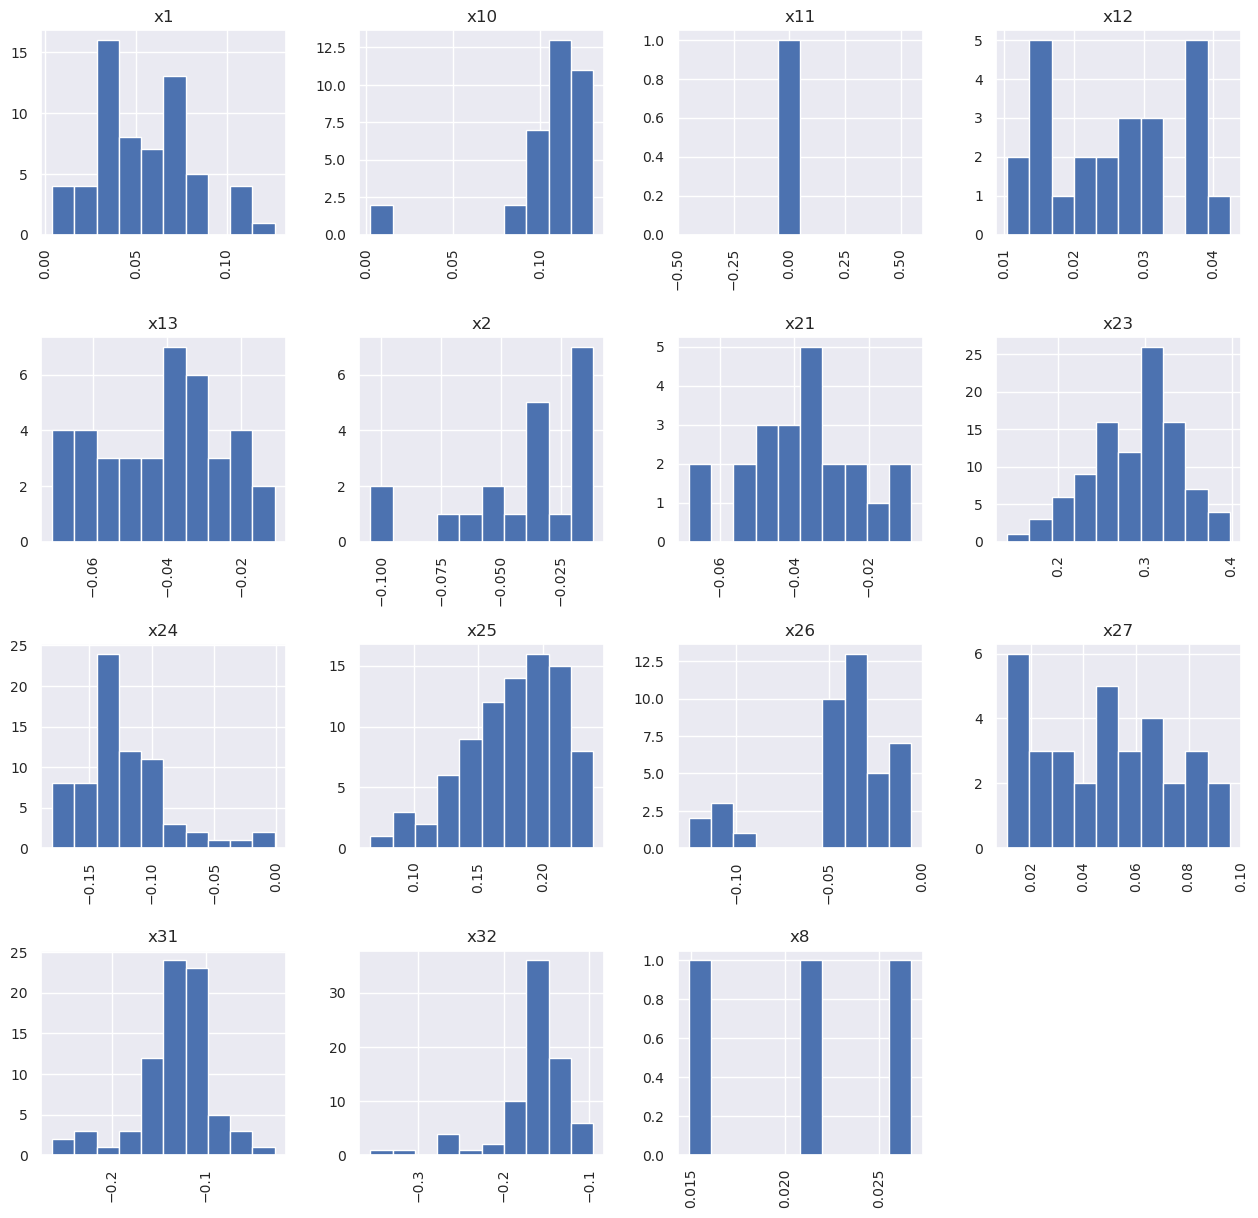

In [22]:
import seaborn.apionly as snsa
snsa.set()
summar.hist(by='selected_feature', column ='coefficient', xlabelsize=10, ylabelsize=10, figsize=(15,15))
plt.show()

Probabilidad de selección de cada variable

In [23]:
summar['selected_feature'].value_counts()

x23    100
x25     86
x32     79
x31     77
x24     72
x1      62
x26     41
x13     39
x10     35
x27     33
x12     24
x21     22
x2      20
x8       3
x11      1
Name: selected_feature, dtype: int64

## Entrenamiento del modelo

In [47]:
MSE = []
accur = []
r2 = []

for j in range(1+1000,101+1000):
    
    train, test = train_test_split(data, test_size = 0.2, random_state=j)
    train=train.drop(['id'], axis=1)
    X_train=train.drop(['y'], axis=1)
    Y_train=train['y']
    test=test.drop(['id'], axis=1)
    X_test=test.drop(['y'], axis=1)
    Y_test=test['y']
    
    num_features = ['x1','x2','x8','x9','x10','x11','x12','x21','x22','x23','x24','x25','x26','x27','x30','x31','x32']
    
    num_pipeline = Pipeline([
        ('scaler',StandardScaler()),
        ('imputer',SimpleImputer(strategy='median'))
        ])
    col_transformer = ColumnTransformer(transformers=[
        ('num', num_pipeline, num_features)
        ])
    
    columns=X_train.columns.values.tolist()    
    col_transformer.fit(X_train.fillna(0))
    X_train[num_features]=col_transformer.transform(X_train.fillna(0))
    X_test[num_features]=col_transformer.transform(X_test.fillna(0))
    
    # Modelo con características seleccionadas
    
    final_model = ElasticNet(alpha=1, l1_ratio=0.1, random_state=0)
    final_model.fit(X_train.filter(['x23', 'x32', 'x25', 'x31', 'x24', 'x1'], axis=1), Y_train)
    y_pred_testor = final_model.predict(X_test.filter(['x23', 'x32', 'x25', 'x31', 'x24', 'x1'], axis=1))
    r2_score_final = r2_score(Y_test, y_pred_testor)
    r2.append(r2_score_final)
    mse = mean_squared_error(Y_test, y_pred_testor)
    MSE.append(mse)
    
    ypt = y_pred_test
    y_pred_test=np.where(y_pred_testor<=-1, 0, 1)
    Y_testn=np.where(Y_test<=-1, 0, 1)
    acc = accuracy_score(Y_testn, y_pred_test)
    accur.append(acc)

#### AUC y Accuracy

In [48]:
summar1 = pd.concat([pd.DataFrame(MSE), pd.DataFrame(accur), pd.DataFrame(r2)],axis=1)

In [49]:
summar1.columns=['MSE','Accuracy','r2']

Distribución del MSE

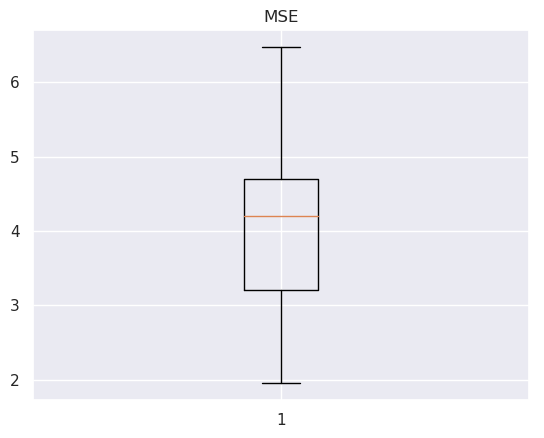

In [50]:
fig1, ax1 = plt.subplots()
ax1.set_title('MSE')
boxplot = ax1.boxplot(summar1['MSE'])

In [51]:
print('Q1:', np.percentile(summar1['MSE'],25))
print('Median:',np.median(summar1['MSE']))
print('Q3:', np.percentile(summar1['MSE'],75))

Q1: 3.206589260804415
Median: 4.2033133031578735
Q3: 4.700129717059494


Distribución accuracy

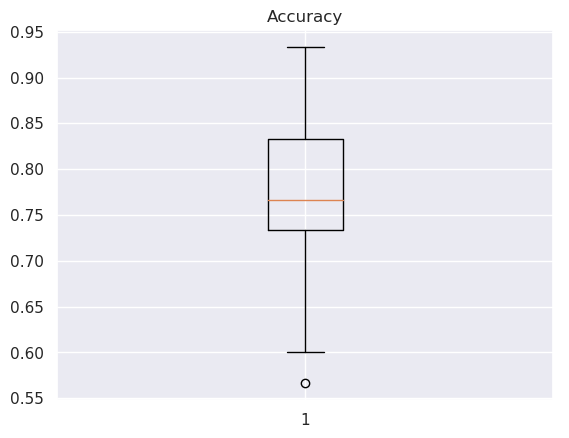

In [52]:
fig2, ax2 = plt.subplots()
ax2.set_title('Accuracy')
boxplot = ax2.boxplot(summar1['Accuracy'])

In [53]:
print('Q1:', np.percentile(summar1['Accuracy'],25))
print('Median:',np.median(summar1['Accuracy']))
print('Q3:', np.percentile(summar1['Accuracy'],75))

Q1: 0.7333333333333333
Median: 0.7666666666666667
Q3: 0.8333333333333334


#### R2 

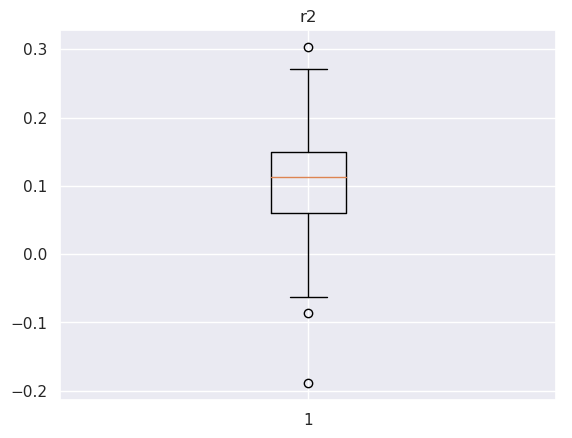

In [54]:
fig2, ax2 = plt.subplots()
ax2.set_title('r2')
boxplot = ax2.boxplot(summar1['r2'])

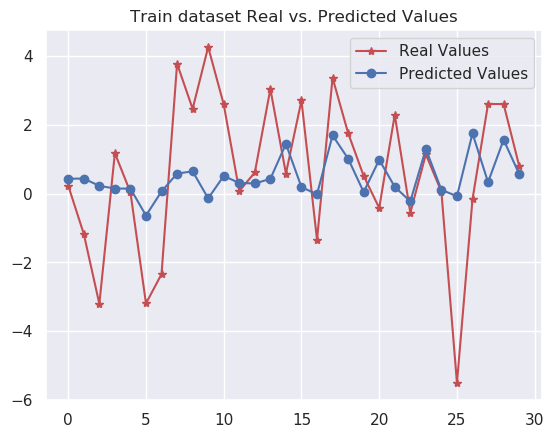

In [55]:

def graf(Y,y_pred):
    plt.plot(range(len(Y)), Y, 'r*-', range(len(Y)), y_pred, 'bo-')
    plt.title('Train dataset Real vs. Predicted Values')
    plt.legend(['Real Values', 'Predicted Values'])
    plt.show()
    #print(MSE)

graf(Y_test,y_pred_testor)

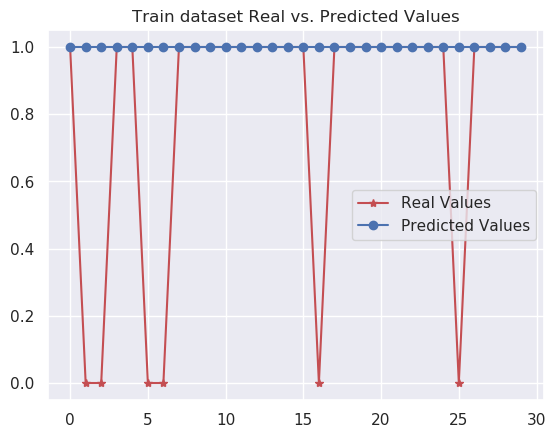

In [56]:
graf(Y_testn,y_pred_test)